# CEBRA Embeddings

### generates CEBRA embeddings from cleaned spike data 

- input: spike data stored in a pickle file, containing datas and recordings
    - datas: list of tensors with neural acivity data
    - recordings: list of mouse ID labels
- output: CEBRA embedding pickle file (saved by name (mouse ID))

**Note:** This pipeline works on both CPU and GPU systems. Training will be faster on GPU but is not required.

Author: @emilyekstrum
<br> 11/17/25

In [ ]:
#load modules
# RUN ME
import cebra
import itertools
import os
import torch
import matplotlib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pickle as pkl
from cebra import CEBRA
from pathlib import Path

plt.style.use(['default', 'seaborn-v0_8-paper'])
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
# Import TDA utilities
# RUN ME

import sys
from pathlib import Path

# add the repo root to path if needed
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# print summary of available data
data_manager.print_summary()

Spike data already available.
Extracting persistence diagrams from all_dgms.zip...
Extracted to: /Users/emilyekstrum/repos/TDA/data/all_dgms
TDA utilities loaded
TDA Data Manager Summary
Workspace root: /Users/emilyekstrum/repos/TDA
Data directory: /Users/emilyekstrum/repos/TDA/data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 4 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 22 .pkl files
  - all_dgms_zip: all_dgms.zip
  X all_dgms_dir: all_dgms

Available spike datasets (8):
  • LGNchromatic_gratings.pkl
  • LGNcolor_exchange.pkl
  • LGNdrifting_gratings.pkl
  • LGNluminance_flash.pkl
  • V1chromatic_gratings.pkl
  and 3 more


## 1. Load and inspect spike data files

In [3]:
# Load spike data
try:
    datas, recordings, dataset_info = data_manager.load_spike_data()
    
    print(f"\nDataset loaded")
    print(f"Dataset: {dataset_info['filename']}")
    print(f"Sessions: {dataset_info['n_sessions']}")
    
    # To load a specific dataset, use:
    # datas, recordings, dataset_info = data_manager.load_spike_data('LGNcolor_exchange.pkl')
    
except Exception as e:
    print(f"Could not load data: {e}")
    print("\nIf issue persists:")
    print("1. Make sure you're in the TDA repository")
    print("2. Check that data/clean_spike_data.zip exists")
    print("3. Or manually add .pkl files to data/clean_spike_data/")

Multiple datasets available:
  1. LGNchromatic_gratings.pkl
  2. LGNcolor_exchange.pkl
  3. LGNdrifting_gratings.pkl
  4. LGNluminance_flash.pkl
  5. V1chromatic_gratings.pkl
  6. V1color_exchange.pkl
  7. V1drifting_gratings.pkl
  8. V1luminance_flash.pkl

Using the first one. To specify, use dataset_name parameter.
Loading dataset: LGNchromatic_gratings.pkl
Loaded 3 recording sessions
  Sessions: ['C155', 'C159', 'C161']
  Data shape: torch.Size([136000, 15])

Dataset loaded
Dataset: LGNchromatic_gratings.pkl
Sessions: 3


## 2. Train CEBRA
- GPU or CPU capabilities
- SKIP TO USE INCLUDED EMBEDDING DATA

## GPU

### or skip and use example embeddings

In [ ]:
train_steps = 30000

single_session = dict()

# use GPUs if avaiable, otherwise use CPU
if torch.cuda.is_available():
    device = 'cuda'
    print("using GPU (CUDA) for training")
else:
    device = 'cpu'
    print("using CPU for training")

cebra_time_model = CEBRA(model_architecture = 'offset10-model',
                        batch_size         = 512,
                        learning_rate      = 3e-4,
                        temperature        = 1,
                        output_dimension   = 3,
                        max_iterations     = train_steps,
                        num_hidden_units   = 128,
                        distance           = 'cosine',
                        conditional        = 'time', # time delta uses behavior/stimulus data to fit model
                        device             = device,
                        verbose            = True,
                        time_offsets       = 10,
                        optimizer          = 'adam',
                        )

# loop through sessions and train CEBRA models
for name, X in zip(recordings, datas):
    print(f"Training model for: {name}")
    single_session[name] = {}

    cebra_time_model.fit(X.type(torch.FloatTensor))
    cebra_time = cebra_time_model.transform(X.type(torch.FloatTensor))

    single_session[name]['model']      = cebra_time_model
    single_session[name]['embedding']  = cebra_time

# save to pickle file
output_filename = f"{dataset_info['filename'].replace('.pkl', '')}_3d_CEBRA_embeddings.pkl"
output_path = data_manager.get_output_path(output_filename, 'CEBRA_embedding_examples')

print(f"\nSaving CEBRA embeddings to: {output_path}")
with open(output_path, 'wb') as f:
    pkl.dump(single_session, f)

print(f"Output file: {output_filename}")

d4


pos: -0.9582 neg:  6.3999 total:  5.4418 temperature:  1.0000: 100%|██████████| 30000/30000 [02:43<00:00, 183.66it/s]


# CPU

### or skip and use example embeddings

- reduced parameters 

In [ ]:
train_steps = 15000  # reduced iterations for faster training

single_session = dict()

# force CPU usage and adjust parameters for CPU performance
device = 'cpu'

cebra_time_model = CEBRA(model_architecture = 'offset10-model',
                        batch_size         = 256,    # smaller batch size
                        learning_rate      = 3e-4,
                        temperature        = 1,
                        output_dimension   = 3,
                        max_iterations     = train_steps,
                        num_hidden_units   = 64,     # smaller hidden units
                        distance           = 'cosine',
                        conditional        = 'time',
                        device             = device,
                        verbose            = True,
                        time_offsets       = 10,
                        optimizer          = 'adam',
                        )

# loop through sessions and train CEBRA models
for name, X in zip(recordings, datas):
    print(f"Training model for: {name}")
    single_session[name] = {}
    cebra_time_model.fit(X.type(torch.FloatTensor))
    cebra_time = cebra_time_model.transform(X.type(torch.FloatTensor))
    single_session[name]['model']      = cebra_time_model
    single_session[name]['embedding']  = cebra_time
    
#save to pickle file
output_filename = f"{dataset_info['filename'].replace('.pkl', '')}_3d_CEBRA_embeddings.pkl"
output_path = data_manager.get_output_path(output_filename, 'CEBRA_embedding_examples')

print(f"\nSaving CEBRA embeddings to: {output_path}")
with open(output_path, 'wb') as f:
    pkl.dump(single_session, f)

print(f"Output file: {output_filename}")

Training model for: C155


pos: -0.5307 neg:  5.8418 total:  5.3111 temperature:  1.0000:   3%|▎         | 410/15000 [00:28<17:11, 14.14it/s]


KeyboardInterrupt: 

## 3. Load in CEBRA model & embedding from pickle file
- use example data file or previously trained model

In [16]:
try:
    # find available CEBRA embedding files in data/CEBRA_embedding_examples/
    cebra_files = data_manager.find_files("*.pkl", "cebra_examples")

    print(f"\n{len(cebra_files)} CEBRA embedding files.")
    for f in cebra_files:
        print(f"    {f.name} - access with index index {cebra_files.index(f)}")
    
    if cebra_files:
        # use the first available file or specifiy by index
        model_path = cebra_files[1]

        print(f"\nLoading CEBRA embedding file: {model_path.name}\n")
        
        # load with CPU mapping for compatibility
        from tda_utils import load_cebra_model_safe
        
        # always force CPU loading to avoid CUDA compatibility issues
        print("Loading model with CPU mapping for compatibility")
        loaded_sessions_cpu, device_info = load_cebra_model_safe(model_path, force_cpu=True)
        
        print(f"Successfully loaded model on: {device_info}")
        print(f"Available sessions: {list(loaded_sessions_cpu.keys())}")
        
        # make the loaded sessions available for plotting
        single_session = loaded_sessions_cpu
        
    else:
        print("No CEBRA models found in data/CEBRA_embedding_examples/")
        print("Either:")
        print("1. Train a model first using the training cells above or")
        print("2. Check that example embedding files are present in the data folder")
        
except Exception as e:
    print(f"Error loading model: {e}")


4 CEBRA embedding files.
    V1_3d_CEBRA_unsup_time_color_exchange.pkl - access with index index 0
    V1_8d_CEBRA_unsup_time_color_exchange.pkl - access with index index 1
    LGN_3d_CEBRA_unsup_time_color_exchange.pkl - access with index index 2
    LGN_8d_CEBRA_unsup_time_color_exchange.pkl - access with index index 3

Loading CEBRA embedding file: V1_8d_CEBRA_unsup_time_color_exchange.pkl

Loading model with CPU mapping for compatibility
Loading model: Using CPU
CUDA compatibility issue detected, forcing CPU mapping
Successfully loaded using custom CPU unpickler
Moving d4 model from cuda:0 to cpu
Successfully loaded model on: Using CPU
Available sessions: ['d4', 'd5', 'd6', 'C153', 'C155', 'C159', 'C160', 'C161']


In [23]:
# RUN ME 
# utils for embedding analysis 

def downsample_embedding(embed, n_target=1000, method="fps", seed=42):
    """ Downsample an embedding to n_target points using farthest pont sampling or random sampling
    
    Args:
        embed : np.ndarray input embedding of shape (N, D).
        n_target : int target number of points after downsampling.
        method : str downsampling method: "random" or "fps" (farthest point sampling).

    Returns:
        np.ndarray: Downsampled embedding of shape (n_target, D).
    """

    N = embed.shape[0]
    if n_target >= N:
        return embed  # nothing to downsample
    
    rng = np.random.default_rng(seed)

    if method == "random":
        idx = rng.choice(N, size=n_target, replace=False)
        return embed[idx]

    #farthest point sampling
    elif method == "fps":
        idxs = [rng.integers(N)]
        dists = np.linalg.norm(embed - embed[idxs[0]], axis=1)

        for _ in range(1, n_target):
            next_idx = np.argmax(dists)
            idxs.append(next_idx)
            new_dists = np.linalg.norm(embed - embed[next_idx], axis=1)
            dists = np.minimum(dists, new_dists)

        return embed[idxs]

    else:
        raise ValueError("method must be 'random' or 'fps'")


def plot_3d_CEBRA(session_dict, session_names, ncols=4):
    """ Plot 3D CEBRA embeddings from session dictionary
    Args:
        session_dict : dict containing session data with embeddings
        session_names : list of session names
        ncols : int number of columns in the plot grid. """
    
    region = model_path.stem.split('_')[0]  # extract region from filename
    dim = model_path.stem.split('_')[1]  # extract dimension from filename
    
    n = len(session_names)
    n_rows = int(np.ceil(n/ncols))

    fig = plt.figure(figsize=(20, 4))

    for n, name in enumerate(session_names):
        embedding = session_dict[name]['embedding']
        
        # first row is default view
        ax = plt.subplot2grid((2, 8), (0, n), projection='3d')
        ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], s=5, alpha=0.3,
                   cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True)
        ax.set_title(name, y=0.8)
        ax.view_init(elev=20, azim=45)  # default view
        
        # second row is 180 deg rotated view
        ax = plt.subplot2grid((2, 8), (1, n), projection='3d')
        ax.scatter(embedding[:,0],
                embedding[:,1],
                embedding[:,2],
                s=5, alpha=0.3,
                cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
                )
        ax.view_init(elev=20, azim=225)  

    for axs in fig.get_axes():
        axs.axis('off')
        axs.grid(False)
        axs.xaxis.pane.fill = False
        axs.yaxis.pane.fill = False
        axs.zaxis.pane.fill = False
        axs.xaxis.pane.set_edgecolor('w')
        axs.yaxis.pane.set_edgecolor('w')
        axs.zaxis.pane.set_edgecolor('w')

    # row labels 
    if len(session_names) > 0:
        fig.text(0.02, 0.7, 'Default\nView', fontsize=12, 
                ha='center', va='center')
        fig.text(0.02, 0.25, '180°\nRotation', fontsize=12, 
                ha='center', va='center')
    
    sm = plt.cm.ScalarMappable(cmap='hsv')
    sm.set_array([])
    
    # colorbar
    cbar_ax = fig.add_axes([0.97, 0.15, 0.008, 0.7]) 
    
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.ax.set_title('Normalized Time\nAcross Trials', pad=10)

    plt.subplots_adjust(wspace=0, hspace=0, right=0.94)  
    plt.suptitle(f'CEBRA Time Embeddings - {region} {dim}', fontsize=20)
    plt.tight_layout()
    plt.show()

# 4. Plot embeddings

Using loaded sessions: ['d4', 'd5', 'd6', 'C153', 'C155', 'C159', 'C160', 'C161']


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_5924/2362355800.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


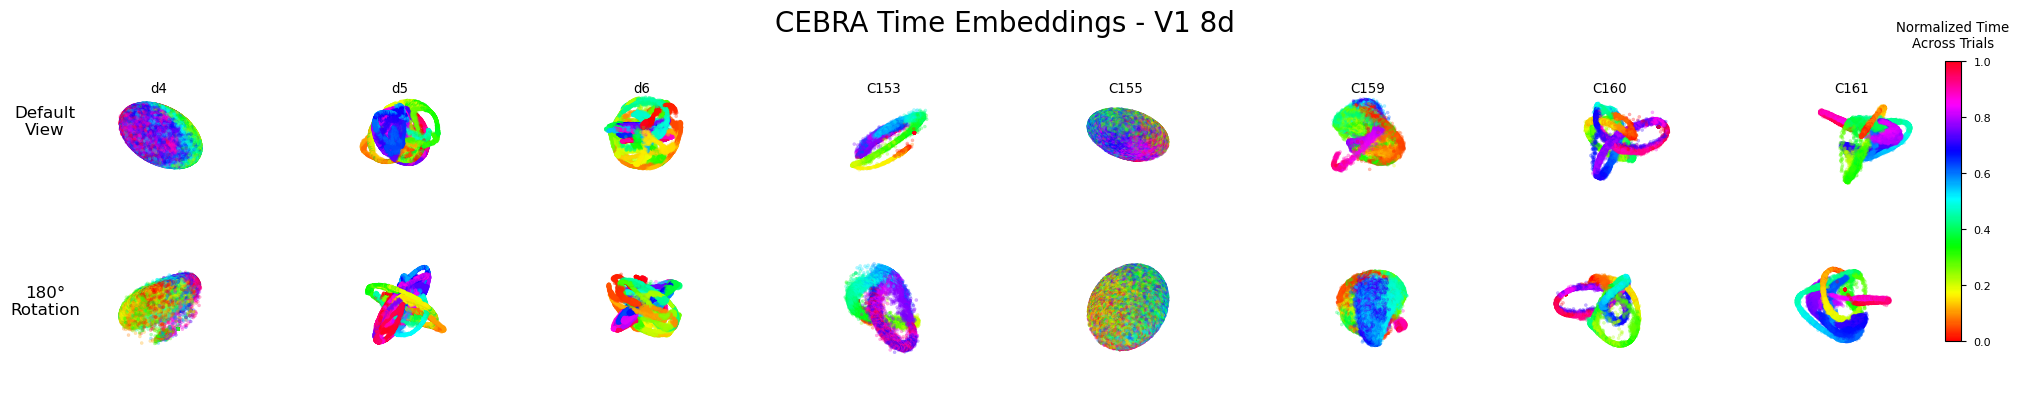

In [24]:
try:
    # check loaded sessions available
    if 'single_session' in locals() and single_session:
        print(f"Using loaded sessions: {list(single_session.keys())}")
        session_dict = single_session
        session_names = list(single_session.keys())
        plot_3d_CEBRA(session_dict, session_names)
        
    else:
        # find and load CEBRA embedding files
        available_embeddings = data_manager.find_files("*.pkl", "cebra_examples")
        
        if available_embeddings:
            print(f"Found {len(available_embeddings)} CEBRA embedding files:")
            for i, path in enumerate(available_embeddings[:5], 1):  # show first 5
                print(f"  {i}. {path.name}")
            
            # use first available embedding file
            embedding_path = available_embeddings[0]
            print(f"\nAttempting to load: {embedding_path.name}")
            
            # load with CPU mapping to avoid CUDA issues
            session_dict, session_names = data_manager.load_embedding_data(embedding_path, force_cpu=True)
            print(f"Successfully loaded and plotting embeddings")
            plot_3d_CEBRA(session_dict, session_names)
            
        else:
            print("No CEBRA embedding files found.")
            print("To fix this issue:")
            print("1. Run one of the training cells above to generate new embeddings")
            print("2. Choose either GPU or CPU training based on your system")
            print("3. Then re-run this plotting cell")
        
except Exception as e:
    print(f"Error plotting embeddings: {e}")
    print("This might be a CUDA/CPU compatibility issue.")
    print("To fix this issue:")
    print("Use the 'Train CEBRA - CPU' cell above to create new embeddings then re-run this cell")